In [22]:
#скачиваем извлеченные признаки
!gdown 1ICRbb7RVW9BjadCZeiF-gFBBZsVqyZpD

Downloading...
From: https://drive.google.com/uc?id=1ICRbb7RVW9BjadCZeiF-gFBBZsVqyZpD
To: /content/flower_images_embs.pickle
100% 17.5M/17.5M [00:00<00:00, 131MB/s]


In [23]:
#скачиваем архив с цветами
!gdown 1KKs9OdYd1I9KgbVQmryRTv1X_MLRH0_d

Downloading...
From: https://drive.google.com/uc?id=1KKs9OdYd1I9KgbVQmryRTv1X_MLRH0_d
To: /content/flowers_arhive.zip
100% 236M/236M [00:03<00:00, 77.1MB/s]


In [27]:
#распакуем архив
!unzip /content/flowers_arhive.zip -d ./

Archive:  /content/flowers_arhive.zip
replace ./flowers/daisy/100080576_f52e8ee070_n.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace ./flowers/daisy/10140303196_b88d3d6cec.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./flowers/daisy/10172379554_b296050f82_n.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [68]:
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
import torch
import glob
import pickle
from tqdm import tqdm
from PIL import Image
!pip3 install pickle5
import pickle5 as pickle
def pil_loader(path):
  #Некоторые изображения из датасета предтавленны не в RGB формате, необходимо их конвертировать в RGB
  with open(path, 'rb') as f:
    img = Image.open(f)
    return img.convert('RGB')

#Step 1: Инициализация модели обученой на датасете imagenet
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights = weights)
model.eval()
preprocess = weights.transforms()

use_precomputed_embeddings = True
emb_filename = '/content/flower_images_embs.pickle'
img_folder = '/content/flowers'
if use_precomputed_embeddings:
  with open(emb_filename, 'rb') as fIn:
    img_names, img_emb_tensors = pickle.load(fIn)
  print("Images:", len(img_names))
else:
  img_names = list(glob.glob(img_folder + '/*/*.jpg'))
  img_emb = []
  #извлечение признаков из изображений в датасете. У меня на CPU заняло около часа
  for image in tqdm (img_names):
    img_emb.append(
        model(preprocess(pil_loader(image)).unsqueeze(0)).squeeze(0).datach().numpy()
    )
  img_emb_tensors = torch.tensor(img_emb)

  with open(emb_filename, 'wb') as handle:
    pickle.dump([img_names, img_emb_tensors], handle, protocol = pickle.HIGHEST_PROTOCOL)  


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Images: 4317


In [70]:
!apt install libomp-dev
!pip install faiss-cpu
import faiss
from sklearn.decomposition import PCA

#функция собирает файс индекс и предварительно уменшает размерность векторов
def build_compressed_index(n_features):
  pca = PCA(n_components = n_features)
  pca.fit(img_emb_tensors)
  compressed_features = pca.transform(img_emb_tensors)
  dataset = np.float32(compressed_features)
  d = dataset.shape[1]   #dimension
  nb = dataset.shape[0] #database size
  xb = dataset

  index_compressed = faiss.IndexFlatL2(d)  #build the index
  index_compressed.add(xb)                # add vectors to the index
  return [pca, index_compressed]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (1:10.0-50~exp1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [81]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def main_image(img_path, desc):
  plt.imshow(mpimg.imread(img_path))
  plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize = 12)
  plt.title(desc,fontsize  = 20)
  plt.show()

def similar_images(indices, suptitle):
  plt.figure(figsize = (15,10), facecolor = 'white')
  plotnumber = 1
  for index in indices [0:4]:
    if plotnumber <= len (indices):
      ax = plt.subplot(2,2,plotnumber)
      plt.imshow(mpimg.imread(img_names[index]))
      plt.xlabel(img_names[index],fontsize = 12)
      plotnumber +=1
  plt.suptitle(suptitle, fontsize = 15)
  plt.tight_layout()

In [82]:
import numpy as np
#пойск , нужно по индексу из предварительно извлечениых изобрвжений или передать новое изображение
def search(query, factors):
  if (type (query) == str):
    img_path = query
  else:
    img_path = img_names[query]
  one_img_emb = torch.tensor(model(preprocess(read_image(img_path)).unsqueeze(0)).squeeze(0).detach().numpy())
  main_image(img_path, 'Query')
  compressor, index_compressed = build_compressed_index(factors)
  D,I = index_compressed.search(np.float32(compressor.transform([one_img_emb.detach().numpy()])),5)
  similar_images(I[0][1:],"faiss compressed " + str(factors))


In [83]:
img_names[250]

'/content/flowers/rose/17062080069_36ac7907d2_n.jpg'

In [84]:
from pprint import pprint
metrics = weights.value.__dict__['meta']['_metrics']
#print(metrics)
print(metrics) 

{'ImageNet-1K': {'acc@1': 80.858, 'acc@5': 95.434}}


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


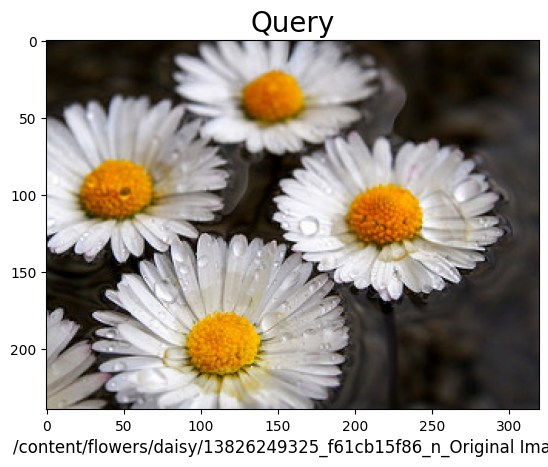

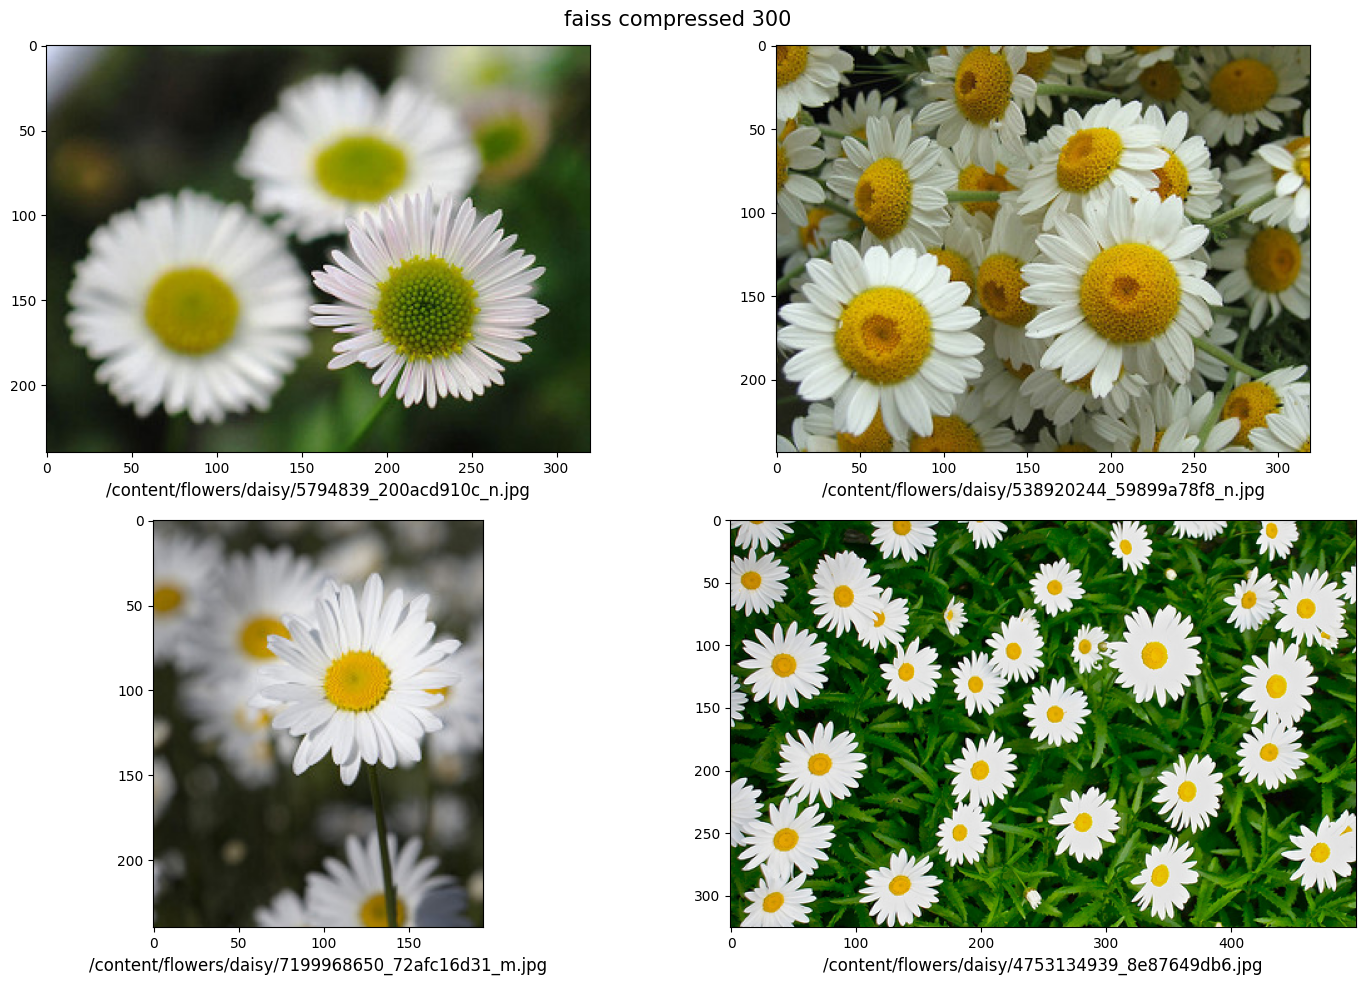

In [85]:
search("/content/flowers/daisy/13826249325_f61cb15f86_n.jpg",300)